In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import pandas as pd

import torch
from GCNmodel import GCN

from torch_geometric.data import DataLoader

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)

# load best training and validation losses
best_train_loss = np.load('best_train_loss.npy')
best_val_loss = np.load('best_val_loss.npy')

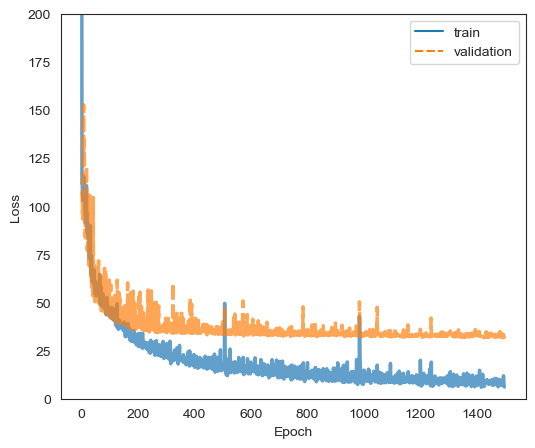

In [7]:
# draw learning curve with seaborn
df = pd.DataFrame({'train': np.sqrt(best_train_loss), 'validation': np.sqrt(best_val_loss)})
sns.set_style("white")
sns.lineplot(data=df, palette="tab10", linewidth=2.5, legend='brief', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 200)
# set figsize to make the same with second one
plt.gcf().set_size_inches(6, 5)
plt.savefig('learning_curve.png')

/Users/pingyang/opt/anaconda3/envs/torch/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


r2_score: 0.9767973390896234
RMSE: 33.20941162109375
MAE: 23.7998046875


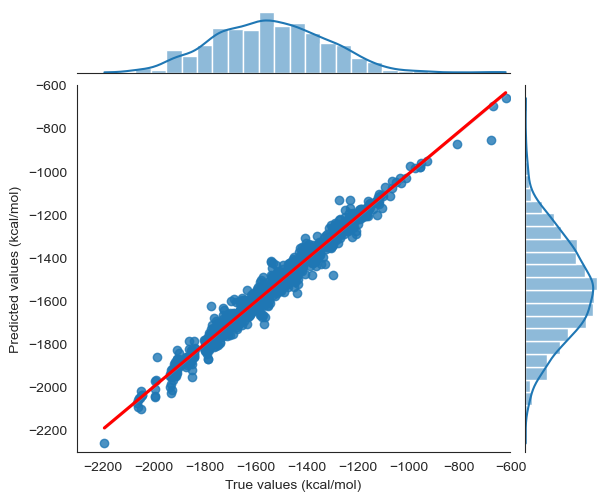

In [8]:
# load the best model
num_features = 5
num_classes = 1
param = best_params
batch_size = 32
model = GCN(num_features, num_classes, hidden_layers=param['hidden_layers'], hidden_size=param['hidden_size'])
model.load_state_dict(torch.load('best_model.pt'))

# load test data
test_data = torch.load('test_data.pt')

# define testing loader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
# predict on test set
model.eval()
preds = []
for data in test_loader:
    out = model(data)
    preds.append(out.detach().numpy())
preds = np.concatenate(preds)

# calculate R2 score
trues = np.concatenate([data.y.detach().numpy() for data in test_loader])
print(f"r2_score: {r2_score(trues, preds)}")

# calculate RMSE
print(f"RMSE: {np.sqrt(mean_squared_error(trues, preds))}")

# calculate MAE
print(f"MAE: {mean_absolute_error(trues, preds)}")

# plot predictions vs. true values using joint plot
# 1-D
trues = trues.reshape(-1)
preds = preds.reshape(-1)
df = pd.DataFrame({'true': trues, 'pred': preds})

sns.set_style("white")
g = sns.jointplot(x='true', y='pred', data=df, kind='reg')
# set x,y lims
g.ax_joint.set_xlim(-2300, -600)
g.ax_joint.set_ylim(-2300, -600)
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)
# labels
plt.xlabel('True values (kcal/mol)')
plt.ylabel('Predicted values (kcal/mol)')
# set figsize to make the same with first one
plt.gcf().set_size_inches(6, 5)
plt.savefig('jointplot.png')